In [19]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


### Dictionary to map file keys from STScI to Krist

In [20]:
prim_key_map = {'luvoir15m':'LUVOIR15m'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## set directory of telescope aperture and list contents

In [21]:
jpl_telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
gsfc_telap_dir = os.path.abspath('../Apertures/GSFC')

#telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
#print telap_dir
#print("Contents:")
#os.listdir(telap_dir)

In [22]:
#new_telap_dir = os.path.abspath("../InputMasks/TelAp")
#new_telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/TelAp")
#new_telap_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_v4/TelAp")
new_telap_dir = os.path.expanduser("~/SCDA/InputMasks/TelAp")
if not os.path.exists(new_telap_dir):
    os.mkdir(new_telap_dir)
    print("created {:s} for binned aperture arrays".format(new_telap_dir))
else:
    print("Destination {:s} already exists".format(new_telap_dir))

Destination /Users/neil/SCDA/InputMasks/TelAp already exists


## Set basic parameters

In [111]:
overwrite = False
prim_key = "luvoir15m"
secobs_key = "X"
centobs = True
Dprim = 4096
Dsec = 2000
N = 256 # quadrant width after binning
symm = 'quart' # set to either 'quart' or 'half'
gap = 2 # minimum segment gap width at N=250 after rounding to binary
strut = 100 # strut thickness parameter; 100 = 10 cm @ 12 m aperture, 25 = 2.5 cm @ 12 m aperture
cut_corner_segs = False

## Load an aperture and a secondary obstruction, plot the product

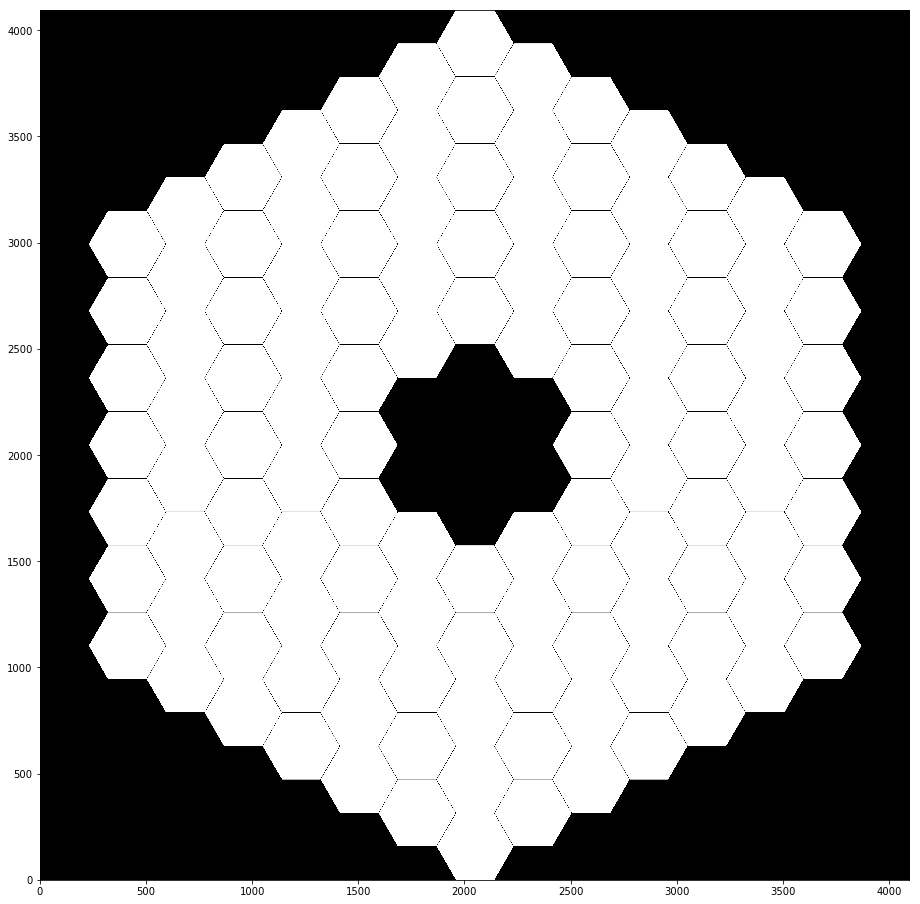

In [82]:
secobs_fname = os.path.join(jpl_telap_dir, "{0:s}_spiders_{1:04d}pix_{2:.1f}cm_offset.fits".format(
                            secobs_key_map[secobs_key], Dsec, float(strut)*0.1))
secobs = fits.getdata(secobs_fname)

prim_fname = os.path.join(gsfc_telap_dir, "{0:s}_{1:04d}pix.fits".format(prim_key_map[prim_key], Dprim))
prim = fits.getdata(prim_fname)

# telap = prim*secobs
telap = prim
    
plt.figure(figsize=(16,16))
plt.imshow(telap)

### Remove segments at corners

In [83]:
L = telap.shape[0]
telap_left = telap[:,:L/2] # left half
telap_right = telap[:,L/2:] # right half
telap_top = telap[L/2:,:] # left half
telap_bot = telap[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 1
Max absolute top-bottom difference = 1


In [ ]:
L = telap.shape[0]


## Pad the primary obscuration features

In [85]:
if gap is 0:
    max_shift = 0.
if gap is 1:
    max_shift = Dprim*1.2/1000
elif gap is 2:
    max_shift = Dprim*1.8/1000
elif gap is 3:
    max_shift = Dprim*2.4/1000
shift_range = np.linspace(-max_shift,max_shift,7)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

print("Shift range on each axis: {}".format(shift_range))
print("Shifting telescope pupil array up to +/-{:.2f} pixels in each direction, using {:d} x,y shift combinations, to build up a padded version".format(max_shift, len(XYshifts_allowed)))

Shift range on each axis: [-7.3728 -4.9152 -2.4576  0.      2.4576  4.9152  7.3728]
Shifting telescope pupil array up to +/-7.37 pixels in each direction, using 29 x,y shift combinations, to build up a padded version


In [86]:
padded_telap = np.ones(telap.shape)
for (xshift,yshift) in XYshifts_allowed:
    shift = skimage.transform.SimilarityTransform(translation=(xshift,yshift))
    telap_shifted = skimage.transform.warp(telap, shift, order=1)
    #telap_shifted = np.roll(np.roll(telap, yshift, 0), xshift, 1)
    padded_telap *= telap_shifted

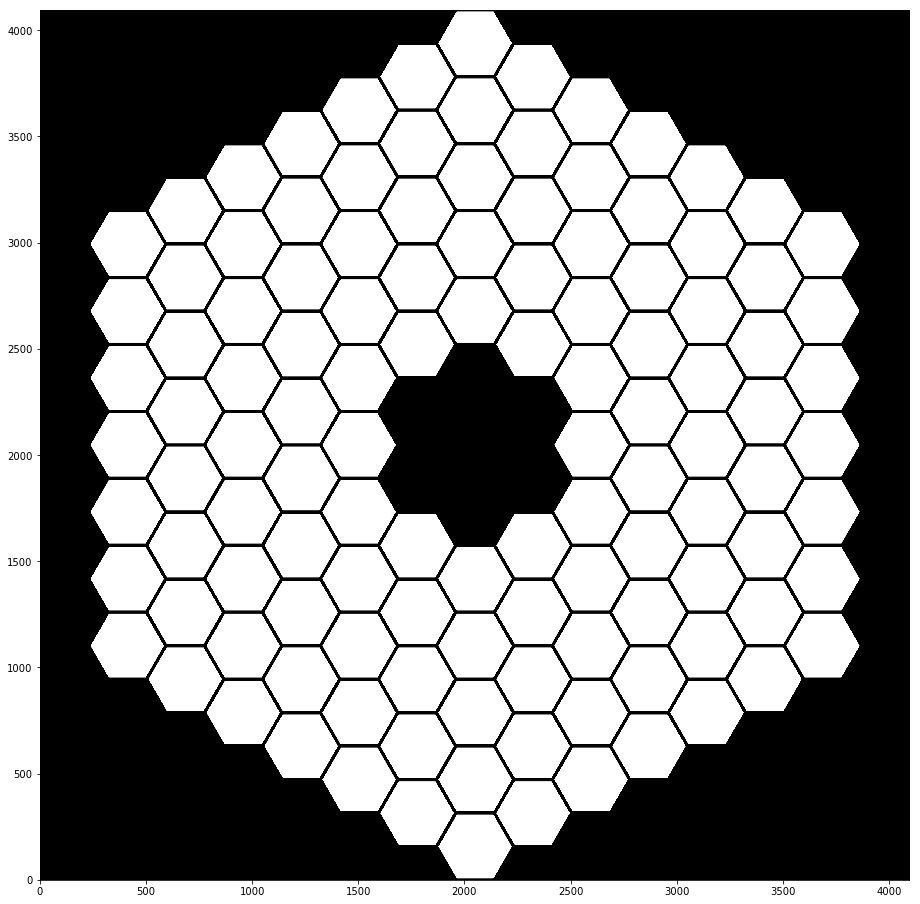

In [87]:
plt.figure(figsize=(16,16))
plt.imshow(padded_telap)

In [88]:
if gap is 0:
    max_shift = 0.
if gap is 1:
    max_shift = Dsec*0.2/1000
elif gap is 2:
    max_shift = Dsec*1.1/1000
elif gap is 3:
    max_shift = Dsec*1.8/1000
shift_range = np.linspace(-max_shift,max_shift,7)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

print("Shift range on each axis: {}".format(shift_range))
print("Shifting telescope pupil array up to +/-{:.2f} pixels in each direction, using {:d} x,y shift combinations, to build up a padded version".format(max_shift, len(XYshifts_allowed)))

Shift range on each axis: [-2.2        -1.46666667 -0.73333333  0.          0.73333333  1.46666667
  2.2       ]
Shifting telescope pupil array up to +/-2.20 pixels in each direction, using 29 x,y shift combinations, to build up a padded version


In [89]:
padded_secobs = np.ones(secobs.shape)
for (xshift,yshift) in XYshifts_allowed:
    shift = skimage.transform.SimilarityTransform(translation=(xshift,yshift))
    secobs_shifted = skimage.transform.warp(secobs, shift, order=1)
    padded_secobs *= secobs_shifted

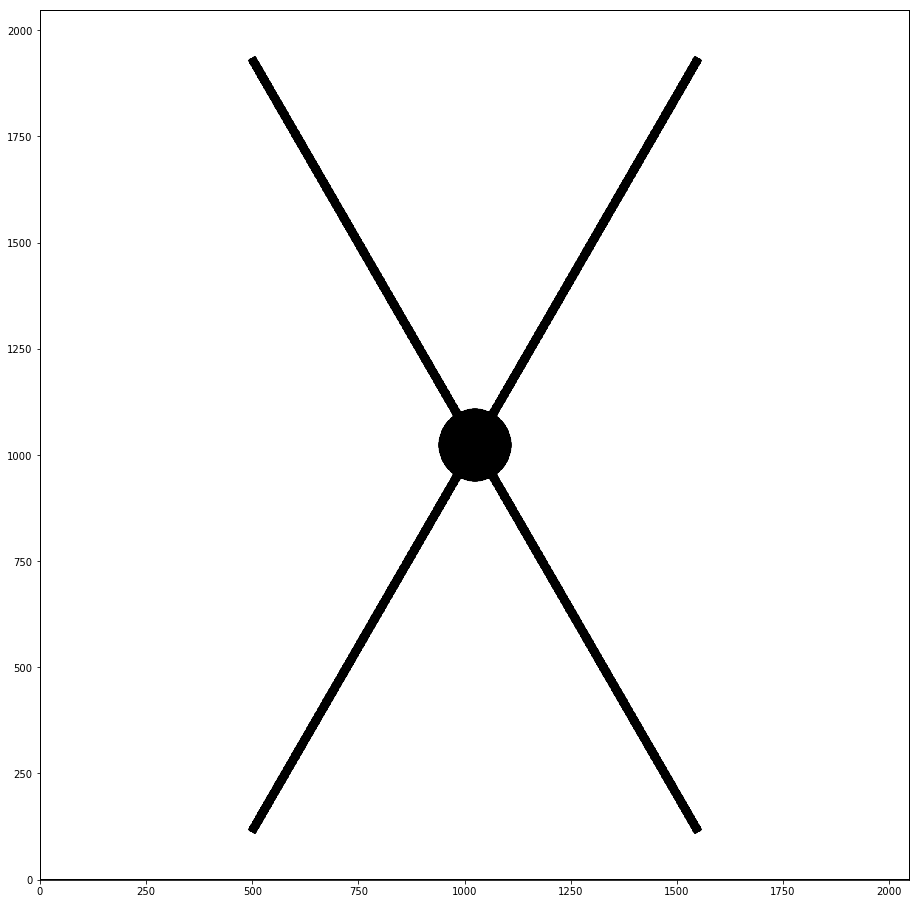

In [90]:
plt.figure(figsize=(16,16))
plt.imshow(padded_secobs)

## Bin to abritrary integer size, crop

In [91]:
#N_orig = D/2
#telap_bin = skimage.transform.resize(padded_telap,(2*N,2*N),order=1)
#L_bin = telap_bin.shape[0]

In [92]:
N_orig = Dprim/2
scalefac = int(N_orig/N)
print("Binning the original aperture array {0:d}x".format(scalefac))
prim_bin = np.reshape(padded_telap,(telap.shape[0]/scalefac, scalefac, 
                                    telap.shape[1]/scalefac, scalefac)).mean(1).mean(2)
L_bin = prim_bin.shape[0]

Binning the original aperture array 8x


In [93]:
N_orig = Dsec/2
#scalefac = int(N_orig/N)
#print("Binning the secondary obscuration array {0:d}x".format(scalefac))

if strut == 100:
    secobs_bin = skimage.transform.resize(secobs,(2*N,2*N),order=1)
else: # only pad the thin strut
    secobs_bin = skimage.transform.resize(padded_secobs,(2*N,2*N),order=1)

In [94]:
telap_bin = prim_bin*secobs_bin

In [95]:
telap_bin.shape

(512, 512)

In [96]:
if symm is 'half':
    telap_bin_crop = telap_bin[L_bin/2-N:L_bin/2+N, L_bin/2:L_bin/2+N]
    print telap_bin_crop.shape
else:
    telap_bin_crop = telap_bin[L_bin/2:L_bin/2+N, L_bin/2:L_bin/2+N]
    print telap_bin_crop.shape
    # Check max value of outer row and outer column
    #print np.max(telap_binquad[-1,:])
    #print np.max(telap_binquad[:,-1])
    
telap_bin_full = telap_bin[L_bin/2-N:L_bin/2+N, L_bin/2-N:L_bin/2+N]

(256, 256)


(-0.5, 255.5, -0.5, 255.5)

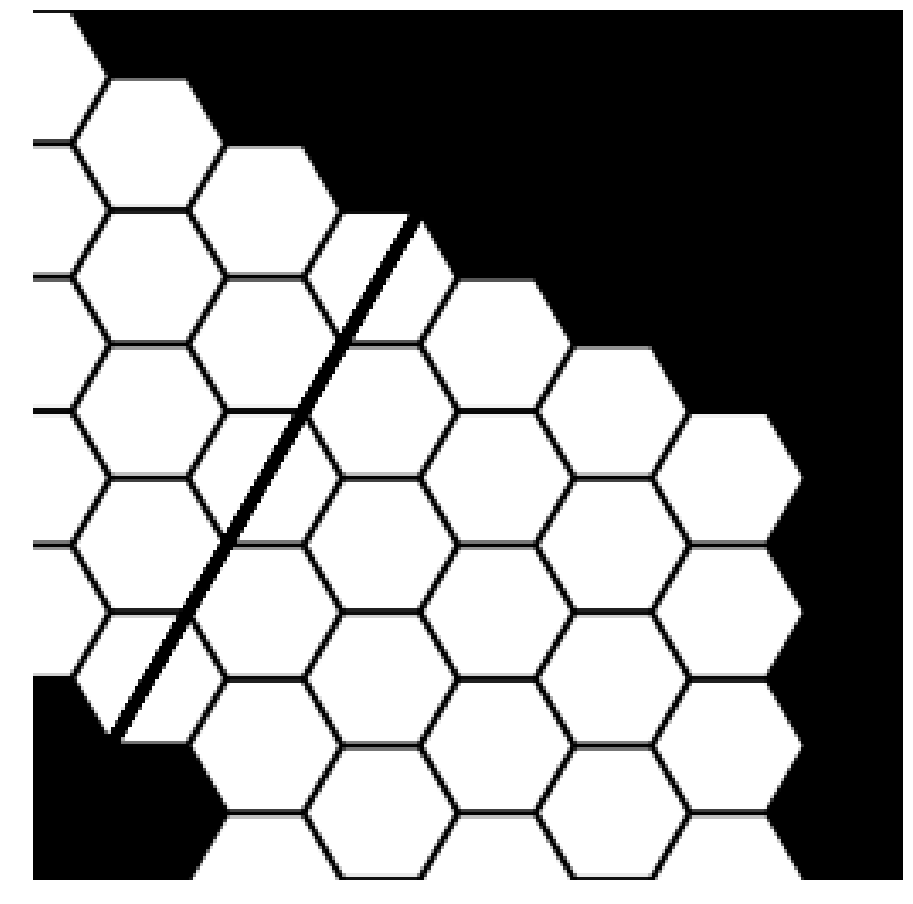

In [97]:
if symm is 'half':
    plt.figure(figsize=(16,32))
    plt.imshow(telap_bin_crop)
else:
    plt.figure(figsize=(16,16))
    plt.imshow(telap_bin_crop)
    #plt.imshow(np.floor(telap_bin_crop))
    #plt.imshow(np.round(telap_bin_crop))
plt.axis('off')

### Form new FITS filename and write

In [98]:
if symm is 'half':
    telap_bin_dat_fname_tail = "TelAp_half_{0:s}{1:s}{2:03d}cobs1gap{3:1d}_N{4:04d}.dat".format(
                                prim_key, secobs_key, strut, gap, N)
    telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)
else:
    telap_bin_dat_fname_tail = "TelAp_quart_{0:s}{1:s}{2:03d}cobs1gap{3:1d}_N{4:04d}.dat".format(
                                prim_key, secobs_key, strut, gap, N)
    telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)

In [99]:
#telap_binquad_hdu = fits.PrimaryHDU(telap_binquad)
#telap_binquad_hdu.writeto(telap_binquad_fits_fname, clobber=True)

In [100]:
if not os.path.exists(telap_bin_dat_fname) or overwrite is True:
    np.savetxt(telap_bin_dat_fname, telap_bin_crop, fmt='%.6f', delimiter=" ")
    print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_bin_dat_fname))
else:
    print("Telescope aperture array {0:s} already exists, will not overwrite".format(telap_bin_dat_fname))

Telescope aperture array /Users/neil/SCDA/InputMasks/TelAp/TelAp_quart_luvoir15mX100cobs1gap2_N0256.dat already exists, will not overwrite


In [101]:
#if os.path.exists(telap_bin_dat_fname): os.remove(telap_bin_dat_fname)

In [102]:
os.listdir(new_telap_dir)

['TelAp_full_circCross025cobs0gap0_N0250.fits',
 'TelAp_full_circCross025cobs0gap1_N0250.fits',
 'TelAp_full_circCross025cobs1gap0_N0250.fits',
 'TelAp_full_circCross025cobs1gap1_N0250.fits',
 'TelAp_full_hex1X025cobs0gap0_N0250.fits',
 'TelAp_full_hex1X025cobs0gap1_N0250.fits',
 'TelAp_full_hex1X025cobs1gap0_N0250.fits',
 'TelAp_full_hex1X025cobs1gap1_N0250.fits',
 'TelAp_full_hex1X025cobs1gap2_N0250.fits',
 'TelAp_full_hex1X025cobs1gap3_N0250.fits',
 'TelAp_full_hex2X025cobs0gap0_N0250.fits',
 'TelAp_full_hex2X025cobs0gap1_N0250.fits',
 'TelAp_full_hex2X025cobs1gap0_N0250.fits',
 'TelAp_full_hex2X025cobs1gap1_N0250.fits',
 'TelAp_full_hex2X025cobs1gap2_N0250.fits',
 'TelAp_full_hex2X025cobs1gap3_N0250.fits',
 'TelAp_full_hex3X025cobs0gap0_N0250.fits',
 'TelAp_full_hex3X025cobs0gap1_N0250.fits',
 'TelAp_full_hex3X025cobs1gap0_N0125.fits',
 'TelAp_full_hex3X025cobs1gap0_N0250.fits',
 'TelAp_full_hex3X025cobs1gap1_N0125.fits',
 'TelAp_full_hex3X025cobs1gap1_N0250.fits',
 'TelAp_full_hex

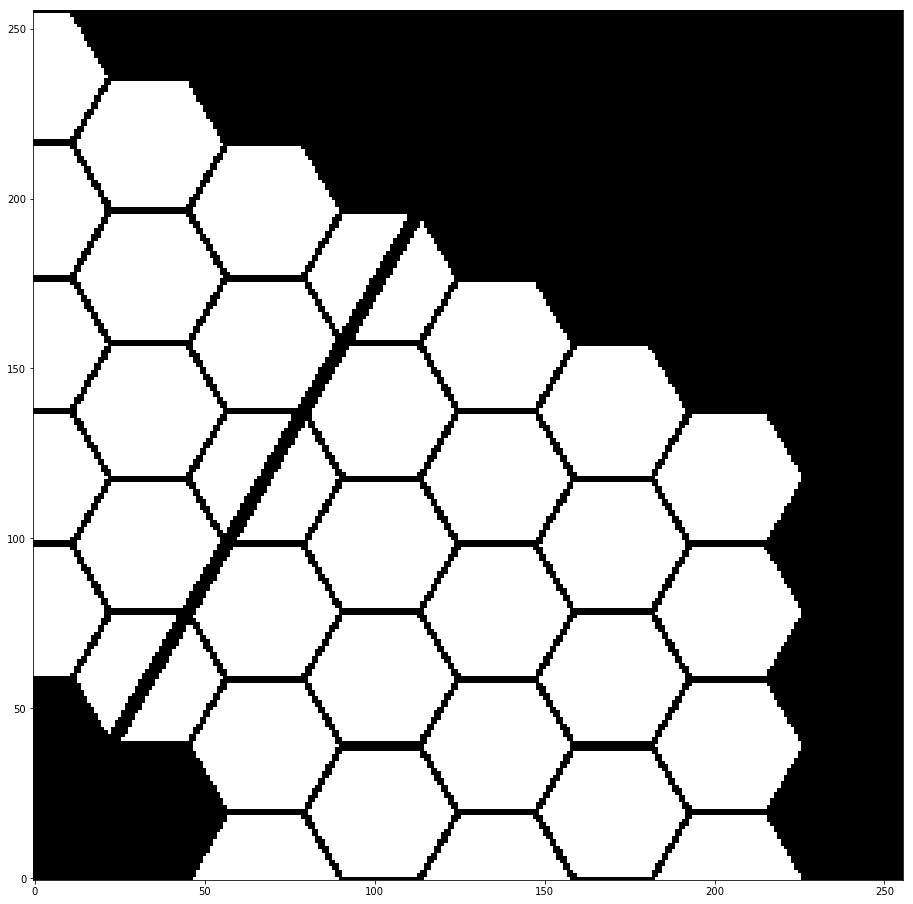

In [103]:
telap_load = np.loadtxt(telap_bin_dat_fname)
plt.figure(figsize=(16,16))
plt.imshow(np.round(telap_load))

(-0.5, 400.5, -0.5, 400.5)

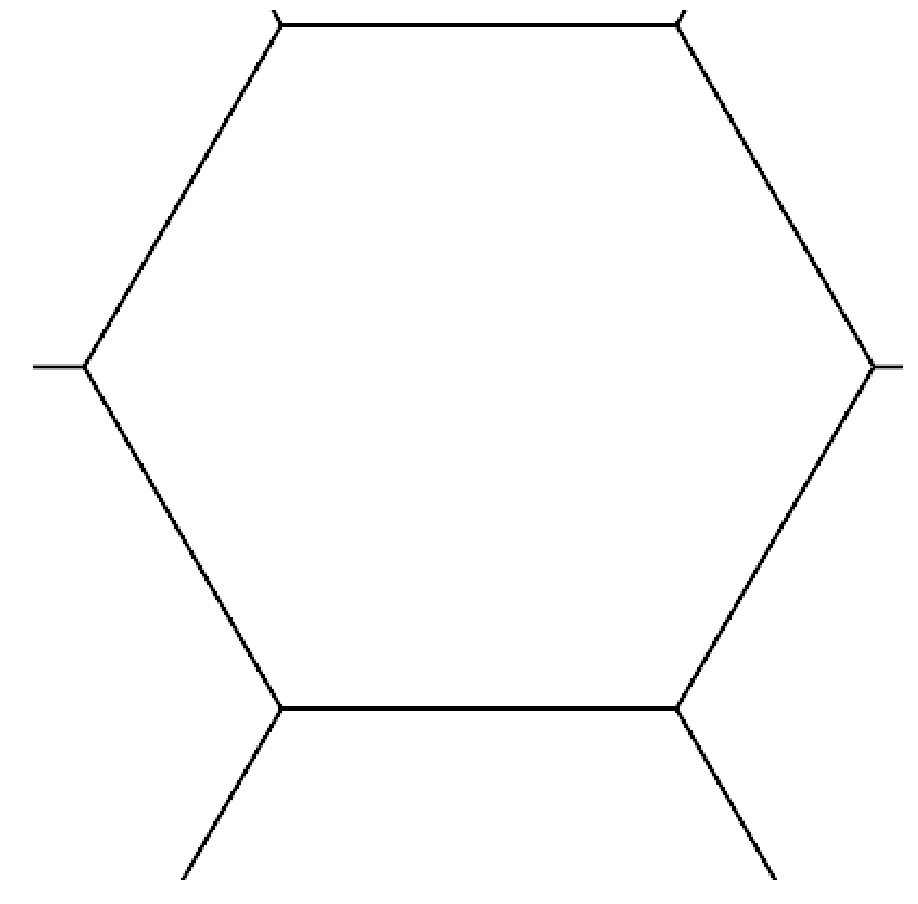

In [104]:
plt.figure(figsize=(16,16))

#plt.imshow(telap[1024:2024,1024:2024])
plt.imshow(telap[1024:1425,1024:1425])
plt.axis('off')

(-0.5, 100.5, -0.5, 100.5)

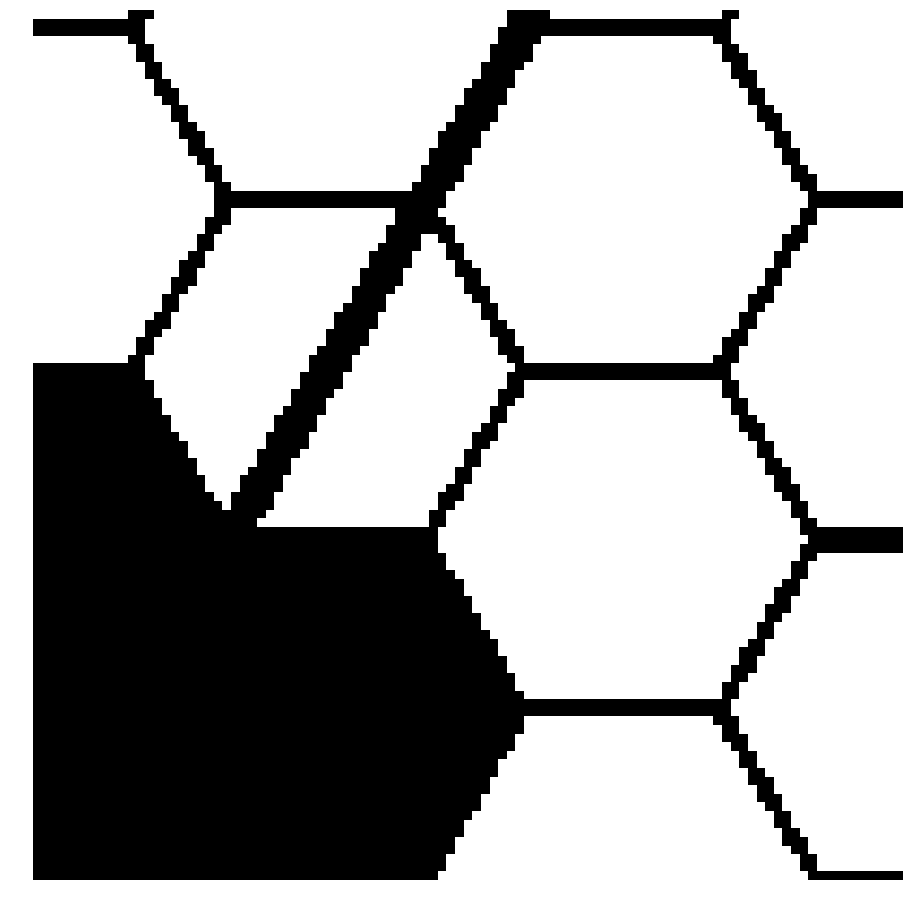

In [105]:
telap_load = np.loadtxt(telap_bin_dat_fname)
plt.figure(figsize=(16,16))
plt.imshow(np.round(telap_load[:101,:101]))
plt.axis('off')

## Write full, rounded telescope pupil to FITS

In [106]:
fits_fname = telap_bin_dat_fname_tail.replace("quart", "full")
fits_fname = fits_fname.replace("half", "full")
fits_fname = fits_fname.replace(".dat", ".fits")
fits_fname = os.path.join(new_telap_dir, fits_fname)

if not os.path.exists(fits_fname) or overwrite==True:
    telap_full_hdu = fits.PrimaryHDU(np.round(telap_bin_full).astype(int))
    telap_full_hdu.writeto(fits_fname, clobber=True)
    print("Wrote full, rounded telescope pupil to {:s}".format(fits_fname))

In [107]:
#os.remove(fits_fname)

In [108]:
print new_telap_dir
os.listdir(new_telap_dir)

/Users/neil/SCDA/InputMasks/TelAp


['TelAp_full_circCross025cobs0gap0_N0250.fits',
 'TelAp_full_circCross025cobs0gap1_N0250.fits',
 'TelAp_full_circCross025cobs1gap0_N0250.fits',
 'TelAp_full_circCross025cobs1gap1_N0250.fits',
 'TelAp_full_hex1X025cobs0gap0_N0250.fits',
 'TelAp_full_hex1X025cobs0gap1_N0250.fits',
 'TelAp_full_hex1X025cobs1gap0_N0250.fits',
 'TelAp_full_hex1X025cobs1gap1_N0250.fits',
 'TelAp_full_hex1X025cobs1gap2_N0250.fits',
 'TelAp_full_hex1X025cobs1gap3_N0250.fits',
 'TelAp_full_hex2X025cobs0gap0_N0250.fits',
 'TelAp_full_hex2X025cobs0gap1_N0250.fits',
 'TelAp_full_hex2X025cobs1gap0_N0250.fits',
 'TelAp_full_hex2X025cobs1gap1_N0250.fits',
 'TelAp_full_hex2X025cobs1gap2_N0250.fits',
 'TelAp_full_hex2X025cobs1gap3_N0250.fits',
 'TelAp_full_hex3X025cobs0gap0_N0250.fits',
 'TelAp_full_hex3X025cobs0gap1_N0250.fits',
 'TelAp_full_hex3X025cobs1gap0_N0125.fits',
 'TelAp_full_hex3X025cobs1gap0_N0250.fits',
 'TelAp_full_hex3X025cobs1gap1_N0125.fits',
 'TelAp_full_hex3X025cobs1gap1_N0250.fits',
 'TelAp_full_hex

## Compute the loss in available energy due to padding of obscuration features

In [109]:
dxb = 1./(2*N)
dx = 1./Dprim
padding_energy_loss_factor = np.sum(np.round(telap_bin_full)*dxb*dxb) / np.sum(np.power(telap,2)*dx*dx)
print("Percentage of available energy from telescope after feature padding = {:.2f}%".format(padding_energy_loss_factor*100))

Percentage of available energy from telescope after feature padding = 89.76%
